In [43]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [37]:
input_path = "../content/DATA_CHAMBER_2021/"
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/DATA_CHAMBER_2021.zip" -d "./"

In [32]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [48]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [110]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class ALEXNET(nn.Module):
    def __init__(self, num_classes: int = 3, dropout: float = 0.5):
        super(ALEXNET, self).__init__()
        self.model = models.alexnet(pretrained=False)   
        self.model = nn.Sequential(*(list(self.model.features.children()) + [nn.AvgPool2d(1), Flatten()] + list(self.model.classifier.children())))
                        
    def forward(self, images):
        scores = self.model(images)
        return scores

In [75]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model = ALEXNET()

In [44]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [76]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [94]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [111]:
def train_model(model, criterion, optimizer, num_epochs=1):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [112]:
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 210/210train loss: 0.0197, acc: 0.9937
Duration :602.5157692432404 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 210/210train loss: 0.0182, acc: 0.9937
Duration :604.6243097782135 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 210/210train loss: 0.0116, acc: 0.9966
Duration :602.3030352592468 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 210/210train loss: 0.0078, acc: 0.9979
Duration :605.5030288696289 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 210/210train loss: 0.0285, acc: 0.9911
Duration :604.6505920886993 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 210/210train loss: 0.0040, acc: 0.9993
Duration :607.2310421466827 seconds
----------------------

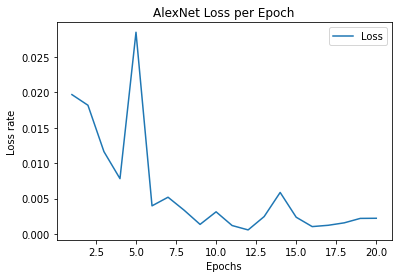

In [113]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("AlexNet Loss per Epoch")
plt.legend()
plt.show()

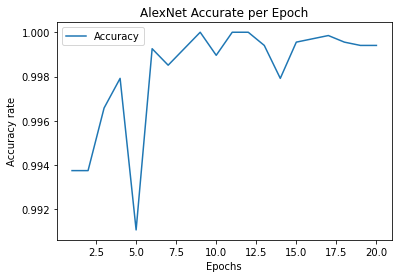

In [114]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("AlexNet Accurate per Epoch")
plt.legend()
plt.show()

In [119]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

              0
0  12102.327148


In [126]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [127]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       409
           1       0.87      0.97      0.91       367
           2       1.00      0.88      0.94       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.91      1607



0.9116365899191039

In [89]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [128]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))


vid: 172 label: 2 pred: 2
vid: 160 label: 2 pred: 2
vid: 189 label: 1 pred: 1
vid: 158 label: 0 pred: 0
vid: 170 label: 2 pred: 2
vid: 171 label: 0 pred: 0
vid: 165 label: 0 pred: 0
vid: 169 label: 0 pred: 1
vid: 185 label: 1 pred: 1
vid: 186 label: 1 pred: 1
vid: 162 label: 1 pred: 1
vid: 159 label: 1 pred: 1
vid: 191 label: 0 pred: 0
vid: 163 label: 2 pred: 2
vid: 167 label: 2 pred: 0
vid: 187 label: 2 pred: 2
vid: 175 label: 1 pred: 1
vid: 174 label: 1 pred: 1
vid: 157 label: 1 pred: 1
vid: 166 label: 1 pred: 1
vid: 193 label: 2 pred: 2
vid: 180 label: 2 pred: 2
vid: 182 label: 2 pred: 2
vid: 179 label: 1 pred: 1
vid: 194 label: 1 pred: 1
vid: 188 label: 2 pred: 2
vid: 178 label: 0 pred: 0
vid: 181 label: 0 pred: 0
vid: 164 label: 2 pred: 2
vid: 168 label: 0 pred: 0
vid: 190 label: 1 pred: 1
vid: 184 label: 2 pred: 2
vid: 183 label: 0 pred: 0
vid: 161 label: 1 pred: 1
vid: 176 label: 0 pred: 0
vid: 173 label: 2 pred: 2
vid: 192 label: 0 pred: 0
vid: 195 label: 2 pred: 2
vid: 177 lab

In [92]:
accuracy_score(y_true,y_pred)

0.9487179487179487